In [6]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_dir = f'{main_dir}/Snapshots/1/Test'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/Dynamics')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'label_encoded_data.pkl'
           })
p.add_node(LoaderNode, None, 'oof',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'oof_best_submit.csv'
           })
p.add_node(LoaderNode, None, 'predictions',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'ieee_with_additions.csv'
           })
p.run(verbose=True)
p.save()

---------------------------
0: LoaderNode [2019-09-22 23:07:13]
params:
 {'input_directory': '../../../Snapshots/1/Test', 'file': 'label_encoded_data.pkl'}
---------------------------
1: LoaderNode [2019-09-22 23:07:18]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'oof_best_submit.csv'}
---------------------------
2: LoaderNode [2019-09-22 23:07:18]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'ieee_with_additions.csv'}


In [8]:
df = p.data['data']
df = df[['isFraud', 'new_card_id']]

In [9]:
pred = pd.concat([p.data['oof'].set_index('TransactionID')['score'],p.data['predictions'].set_index('TransactionID')['isFraud']],axis=0)#
pred.index

Int64Index([2987000, 2987001, 2987002, 2987003, 2987004, 2987005, 2987006,
            2987007, 2987008, 2987009,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=1097231)

In [10]:
pred

TransactionID
2987000    0.013343
2987001    0.008355
2987002    0.003535
2987003    0.001327
2987004    0.002611
             ...   
4170235    0.003432
4170236    0.002554
4170237    0.003562
4170238    0.003217
4170239    0.002311
Length: 1097231, dtype: float64

In [11]:
df['pred_0'] = pred

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df

,isFraud,new_card_id,pred_0
TransactionID,,,
2987000,0,130935,0.013343
2987001,0,47322,0.008355
2987002,0,40076,0.003535
2987003,0,9790,0.001327
2987004,0,113643,0.002611
...,...,...,...
4170235,-1,21517,0.003432
4170236,-1,9161,0.002554
4170237,-1,48339,0.003562


In [13]:
test = df[['pred_0','new_card_id']].groupby('new_card_id').shift()

In [14]:
shifts = {}
for shift in range(-40,40):
    s = df[['pred_0','new_card_id']].groupby('new_card_id').shift(shift)['pred_0']
    shifts[shift] = s

In [15]:
for k,v in shifts.items():
    if k!=0:
        df[f'pred_{k}']=v

c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df = df.fillna(-1)

In [17]:
X = df[df.isFraud>=0].drop(['isFraud'],axis=1)
y = df[df.isFraud>=0]['isFraud']
test = df[df.isFraud<0].drop(['isFraud'],axis=1)


In [18]:
X

,new_card_id,pred_0,pred_-40,pred_-39,pred_-38,pred_-37,pred_-36,pred_-35,pred_-34,pred_-33,...,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,130935,0.013343,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987001,47322,0.008355,0.013368,0.006630,0.002676,0.073622,0.000741,0.012029,0.001162,0.001448,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987002,40076,0.003535,0.002538,0.007914,0.001416,0.001098,0.005041,0.001437,0.000707,0.006101,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987003,9790,0.001327,0.002424,0.000991,0.000967,0.000996,0.000889,0.000912,0.001205,0.001039,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987004,113643,0.002611,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,36490,0.002267,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577536,115832,0.004644,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577537,46747,0.003130,0.022940,0.000839,0.003134,0.001307,0.004710,0.008165,0.005719,0.002745,...,0.002601,0.012045,0.001989,0.001560,0.001983,0.001599,0.005857,0.001936,0.014402,0.002610


In [19]:
categorical_features = [c for c, col in enumerate(X.columns) if col in ['new_card_id']]


In [24]:
params = {'num_leaves': 200,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'max_bin': 50,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5899927210061127,
          'reg_lambda': 0.8485237330340494,
          'random_state': 47, 
          'categorical_feature': categorical_features,
         }


In [25]:
from sklearn.model_selection import KFold
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [26]:
from BayDS.lib.training import *

Fold 1 started at Sun Sep 22 23:11:53 2019
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.969329	training's auc: 0.969328	valid_1's auc: 0.91521	valid_1's auc: 0.91521
[200]	training's auc: 0.977903	training's auc: 0.977903	valid_1's auc: 0.918651	valid_1's auc: 0.918656
[300]	training's auc: 0.98284	training's auc: 0.98284	valid_1's auc: 0.919468	valid_1's auc: 0.919466
[400]	training's auc: 0.985739	training's auc: 0.985739	valid_1's auc: 0.919876	valid_1's auc: 0.919878
[500]	training's auc: 0.987801	training's auc: 0.987801	valid_1's auc: 0.920242	valid_1's auc: 0.920246
[600]	training's auc: 0.989185	training's auc: 0.989185	valid_1's auc: 0.920194	valid_1's auc: 0.92019
[700]	training's auc: 0.990299	training's auc: 0.990298	valid_1's auc: 0.919914	valid_1's auc: 0.919914
[800]	training's auc: 0.991403	training's auc: 0.991403	valid_1's auc: 0.919596	valid_1's auc: 0.919597
[900]	training's auc: 0.992121	training's auc: 0.992122	valid_1's 

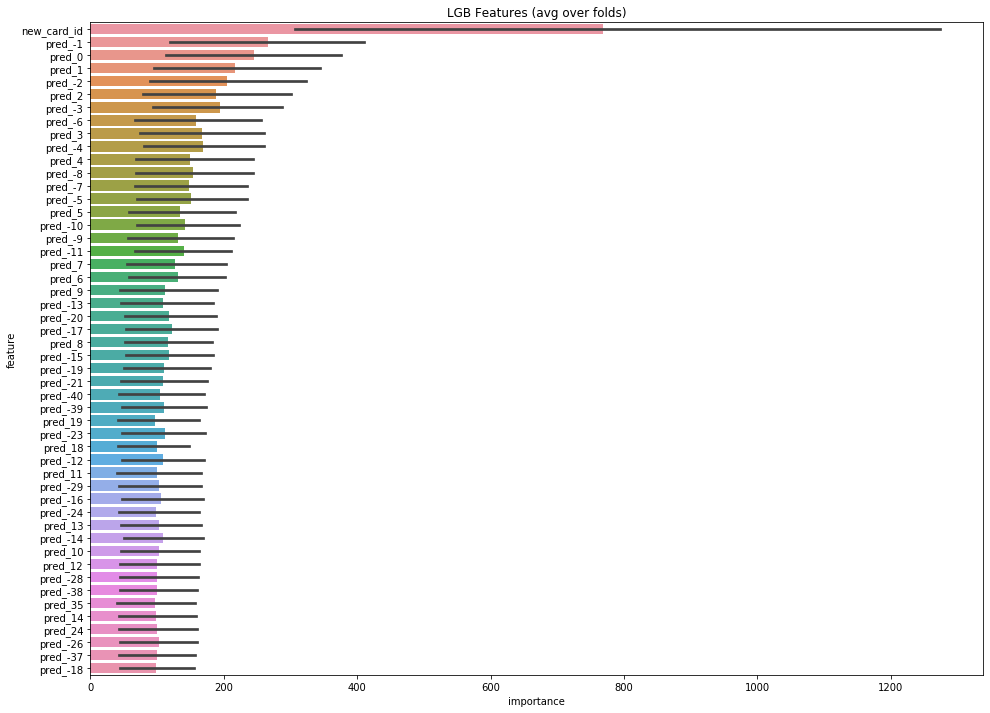

In [27]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=100, early_stopping_rounds=1000, n_estimators=5000, averaging='usual', groups=None)

In [28]:
import pickle
pickle.dump(result_dict_lgb, open(f'{p.working_folder}/results_dict_lgbm_40.pkl','wb'))

In [29]:
# test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [30]:
# folder_path = './data/'
sub = pd.read_csv(f'{data_path}/sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test['prediction'], on='TransactionID')['prediction']
sub.to_csv(f'{p.working_folder}/submission_dynamic_lgbm_40.csv', index=False)